In [51]:
import sys; sys.path.append('../../') 

from utils.data_cleaner import *
from data_collection_config import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### Чтение и подготовка данных

In [52]:
Goods = pd.read_csv(f'{CLEAR_DIRECTORY}{CLEAR_GOODS_FILE}')
Other_characteristicks = pd.read_csv(f'{CLEAR_DIRECTORY}{CLEAR_OTHER_CHARACTERISTICKS_FILE}')
Feedbacks = pd.read_csv(f'{CLEAR_DIRECTORY}{CLEAR_FEEDBACKS_FILE}')

def prepare_goods(df):
    df['brand'] = df['brand'].fillna('Unknown')
    df['description'] = df['description'].fillna('')
    df['brand'] = df['brand'].str.lower().str.strip()

    # mask = df['name'].apply(is_relevant())
    # df = df[mask].copy()
    
    return df

def prepare_other_chars(df):
    df['name'] = df['name'].str.lower().str.strip()
    df['value'] = df['value'].str.lower().str.strip()
    
    df = df[df['value'].notna() & (df['value'] != '')]
    
    return df

def prepare_feedbacks(df):
    df['text'] = df['text'].fillna('')
    
    df['text'] = df['text'].str.lower().str.strip()
    
    return df

Goods = prepare_goods(Goods)
Goods = Goods[(Goods['price'] >= Goods['price'].quantile(0.01)) & (Goods['price'] <= Goods['price'].quantile(0.95))]
Other_characteristicks = prepare_other_chars(Other_characteristicks)
Feedbacks = prepare_feedbacks(Feedbacks)

# Goods.info()
# Other_characteristicks.info()
# Feedbacks.info()

## Выделение главных характеристик

In [53]:
print("Всего уникальных характеристик:", Other_characteristicks['name'].nunique())
print(Other_characteristicks['name'].value_counts().head(50))

Всего уникальных характеристик: 41
name
комплектация                             420
артикул                                  387
тип                                      345
цвет                                     313
зоны массажа                             307
страна-изготовитель                      298
вид массажа                              260
упаковка                                 224
гарантийный срок                         173
материал корпуса                         157
особенности массажного аппарата          144
страна производства                      133
фактический размер товара, см             96
высота предмета                           89
ширина предмета                           87
назначение электродов                     84
вид питания                               71
количество программ/режимов               61
вес товара без упаковки (г)               54
размер электродов                         52
количество предметов в упаковке (шт.)     51
вид аппаратной 

In [54]:
pivot_df = Other_characteristicks.pivot_table(
    index=['good_id', 'marketplace'],
    columns='name',
    values='value',
    aggfunc='first'
).reset_index()

pivot_df.columns.name = None

pivot_df

,good_id,marketplace,артикул,бренд,вес товара (кг),вес товара без упаковки (г),"вес товара, г",вид аппаратной процедуры,вид комплектующего,вид массажа,...,совместимость,страна производства,страна-изготовитель,тип,тип комплектующего,упаковка,"фактический размер товара, см",цвет,ширина предмета,"ширина, см"
0,38851805,wb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,сша,NaN,NaN,NaN,NaN,NaN,NaN,5 см,NaN
1,38854548,wb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,сша,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,38855644,wb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,сша,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,63585106,wb,NaN,NaN,NaN,0.26 г,NaN,NaN,NaN,NaN,...,NaN,тайвань,NaN,NaN,NaN,NaN,NaN,NaN,6 см,NaN
4,63585108,wb,NaN,NaN,NaN,0.26 г,NaN,NaN,NaN,NaN,...,NaN,тайвань,NaN,NaN,NaN,NaN,NaN,NaN,6 см,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,2839516708,ozon,2839516708,NaN,NaN,NaN,NaN,NaN,NaN,"антицеллюлитный, импульсный, лечебный, миостим...",...,NaN,NaN,китай,аксессуар для массажера,NaN,зип-пакет,NaN,10 штук,NaN,NaN
456,2839516740,ozon,2839516740,NaN,NaN,NaN,NaN,NaN,NaN,"антицеллюлитный, импульсный, лечебный, миостим...",...,NaN,NaN,китай,аксессуар для массажера,NaN,зип-пакет,NaN,20 штук,NaN,NaN
457,2839523972,ozon,2839523972,NaN,NaN,NaN,NaN,NaN,NaN,"вибрационный, миостимулирующий, расслабляющий",...,NaN,NaN,китай (гонконг),массажер электрический,NaN,пакет,"15х6х0,3",бело-синий,NaN,NaN
458,2853225065,ozon,2853225065,NaN,NaN,NaN,NaN,NaN,NaN,"антицеллюлитный, импульсный, миостимулирующий,...",...,NaN,NaN,китай,аксессуар для массажера,NaN,пакет,NaN,"носки, серый",NaN,NaN


In [55]:
key_characteristics = {
    "материал": ["материал корпуса", "материал", 'покрытие'],
    "количество_в_упаковке": [
        "количество предметов в упаковке (шт.)", 
        "количество предметов в упаковке",
        "количество в упаковке, шт",
        "единиц в одном товаре"
    ],
    
}

def merge_columns_simple(df, merge_dict):
    result_df = df.copy()
    
    for new_name, old_names in merge_dict.items():
        existing_cols = [col for col in old_names if col in result_df.columns]
        
        if len(existing_cols) > 1:
            print(f"Объединяем {existing_cols} в {new_name}")
            
            merged_values = []
            for idx in range(len(result_df)):
                values = []
                for col in existing_cols:
                    val = result_df.iloc[idx][col]
                    if pd.notna(val) and str(val).strip() != '':
                        values.append(str(val))
                
                if values:
                    merged_values.append(' / '.join(values))
                else:
                    merged_values.append(None)
            
            result_df = result_df.drop(columns=existing_cols)
            result_df[new_name] = merged_values
            
        elif len(existing_cols) == 1:
            result_df = result_df.rename(columns={existing_cols[0]: new_name})
    
    return result_df

standardized_df = merge_columns_simple(pivot_df, key_characteristics)

Объединяем ['материал корпуса', 'материал', 'покрытие'] в материал
Объединяем ['количество предметов в упаковке (шт.)', 'количество предметов в упаковке', 'количество в упаковке, шт', 'единиц в одном товаре'] в количество_в_упаковке


In [56]:
standardized_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   good_id                             460 non-null    int64 
 1   marketplace                         460 non-null    object
 2   артикул                             387 non-null    object
 3   бренд                               20 non-null     object
 4   вес товара (кг)                     1 non-null      object
 5   вес товара без упаковки (г)         40 non-null     object
 6   вес товара, г                       2 non-null      object
 7   вид аппаратной процедуры            31 non-null     object
 8   вид комплектующего                  30 non-null     object
 9   вид массажа                         260 non-null    object
 10  вид питания                         71 non-null     object
 11  высота предмета                     62 non-null     object

In [57]:
desired_characteristics = [
    'good_id',
    'marketplace',
    'зоны массажа',
    'вид массажа',
    'материал',
    'назначение электродов',
    'количество_в_упаковке',
]

final_columns = [col for col in desired_characteristics if col in standardized_df.columns]
main_specs = standardized_df[final_columns]

main_specs['количество_в_упаковке'] = main_specs['количество_в_упаковке'].str.replace(r'\D', '', regex=True)

main_specs

/var/folders/x5/m9f65fq57_1642g0ls7c0zxw0000gn/T/ipykernel_71706/1085390735.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_specs['количество_в_упаковке'] = main_specs['количество_в_упаковке'].str.replace(r'\D', '', regex=True)


,good_id,marketplace,зоны массажа,вид массажа,материал,назначение электродов,количество_в_упаковке
0,38851805,wb,NaN,NaN,None,NaN,4
1,38854548,wb,NaN,NaN,None,миостимуляция,None
2,38855644,wb,NaN,NaN,None,NaN,2
3,63585106,wb,NaN,NaN,None,миостимулятор,6
4,63585108,wb,NaN,NaN,None,миостимулятор,6
...,...,...,...,...,...,...,...
455,2839516708,ozon,"голова, лицо, ноги, область вокруг глаз, плечи...","антицеллюлитный, импульсный, лечебный, миостим...",силикон,NaN,None
456,2839516740,ozon,"голова, лицо, ноги, область вокруг глаз, плечи...","антицеллюлитный, импульсный, лечебный, миостим...",силикон,NaN,None
457,2839523972,ozon,"ноги, руки, тело, шея, спина, ягодицы","вибрационный, миостимулирующий, расслабляющий","мдф, металл",NaN,None
458,2853225065,ozon,"ноги, тело","антицеллюлитный, импульсный, миостимулирующий,...",нейлон,NaN,None


In [58]:
Other_characteristicks

,good_id,marketplace,name,value
0,462063045,wb,артикул,462063045
1,462063045,wb,комплектация,электроды для массажера миостимулятора - 2 или...
2,462063045,wb,ширина предмета,13 см
3,462063045,wb,высота предмета,14 см
4,462063045,wb,комплектация,электроды для массажера миостимулятора - 2 или...
...,...,...,...,...
4060,1331348894,ozon,"фактический размер товара, см",16*16
4061,1331348894,ozon,упаковка,пластиковый пакет
4062,1331348894,ozon,страна-изготовитель,китай
4063,1331348894,ozon,вид массажа,"акупрессурный, антицеллюлитный, импульсный, ле..."


# Анализ рынка электродов для электростимуляторов

## Введение

Необходимо понять, как выглядит текущая рыночная ситуация на рынке электродов для электростимуляторов. 

Были сформулированы 4 цели:
- Определить, в каком ценовом сегменте выгоднее всего конкурировать
- Понять, какие функции и характеристики наиболее популярны у потребителей
- Оценить уровень конкуренции
- Выявить возможные ниши

## Описание источников и подхода к сбору данных

Для достижения поставленных целей в первую очередь необходимо подготовить набор данных. Данные собраны с двух маркетплейсов: Wildberries и Ozon.
Для этих маркетплейсов были разработаны парсеры с помощью Python + requests/Selenium. Парсеры организованы в 2 класса: WB_Parser и Ozon_Parser. Данные классы имеют 3 открытых метода: 
- get_products() - собирает все имеющиеся товары на маркетплейсе, соответсвующие запросу; 
- get_product_feedbacks() - собирает отзывы на заданный товар;
- get_product_details() - собирает описание и характеристики заданного товара.

С обоих площадок было собрано > 2 000 товаров.

После сбора, данные были очищены и собраны в 3 таблицы:
- Goods (основные характеристики товаров)
- Feedbacks (отзывы пользователей)
- Other_characteristics (доп. характеристики)

В итоге получилось >400 товаров и >25 000 отзывов о них

Состав таблиц:

In [59]:
Goods.info()
Other_characteristicks.info()
Feedbacks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 443 entries, 0 to 471
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           443 non-null    int64  
 1   marketplace  443 non-null    object 
 2   name         443 non-null    object 
 3   price        443 non-null    int64  
 4   rating       443 non-null    float64
 5   feedbacks    443 non-null    int64  
 6   brand        443 non-null    object 
 7   description  443 non-null    object 
dtypes: float64(1), int64(3), object(4)
memory usage: 31.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4065 entries, 0 to 4064
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   good_id      4065 non-null   int64 
 1   marketplace  4065 non-null   object
 2   name         4065 non-null   object
 3   value        4065 non-null   object
dtypes: int64(1), object(3)
memory usage: 127.2+ KB
<class 'pandas

## Как выглядит рынок электродов? (Распределение цен)

In [60]:
price_data = Goods['price'].copy()

stats = {
    'Средняя цена': f"{price_data.mean():,.0f} руб",
    'Медианная цена': f"{price_data.median():,.0f} руб",
    'Минимальная цена': f"{price_data.min():,.0f} руб",
    'Максимальная цена': f"{price_data.max():,.0f} руб",
    'Стандартное отклонение': f"{price_data.std():,.0f} руб",
    '95-й перцентиль': f"{price_data.quantile(0.95):,.0f} руб"
}

print("Ключевые метрики распределения цен:")
for k, v in stats.items():
    print(f"{k}: {v}")

Ключевые метрики распределения цен:
Средняя цена: 650 руб
Медианная цена: 395 руб
Минимальная цена: 120 руб
Максимальная цена: 3,186 руб
Стандартное отклонение: 613 руб
95-й перцентиль: 2,118 руб


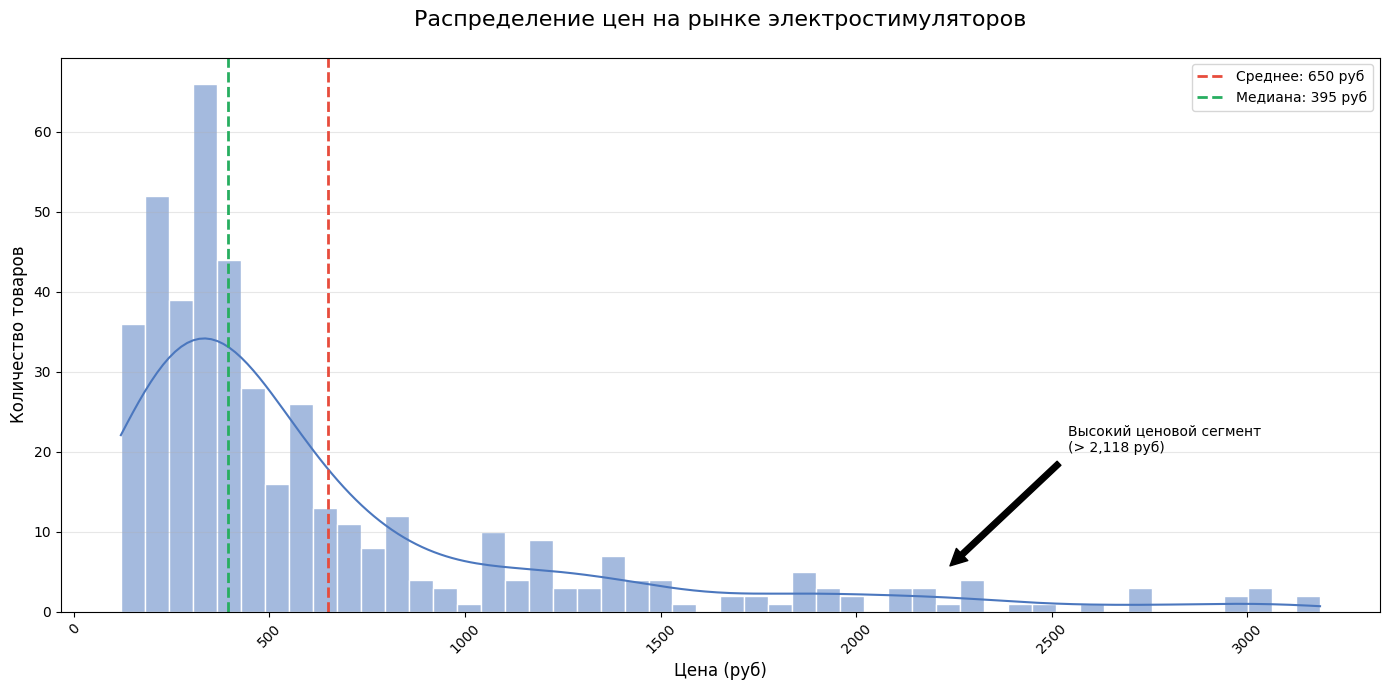

In [61]:
price_data = Goods["price"]

plt.figure(figsize=(14, 7))

ax = sns.histplot(price_data, bins=50, kde=True, 
                 color='#4B77BE', edgecolor='white')

mean_price = price_data.mean()
median_price = price_data.median()

plt.axvline(mean_price, color="#E74C3C", linestyle='--', 
           linewidth=2, label=f'Среднее: {mean_price:,.0f} руб')
plt.axvline(median_price, color='#27AE60', linestyle='--',
           linewidth=2, label=f'Медиана: {median_price:,.0f} руб')

q95 = price_data.quantile(0.95)
outliers = price_data[price_data > q95]
if len(outliers) > 0:
    plt.annotate(f'Высокий ценовой сегмент\n(> {q95:,.0f} руб)',
                xy=(q95*1.05, 5), xytext=(q95*1.2, 20),
                arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Распределение цен на рынке электростимуляторов\n', fontsize=16)
plt.xlabel('Цена (руб)', fontsize=12)
plt.ylabel('Количество товаров', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [62]:
from sklearn.cluster import KMeans

price_segment_clear_df = Goods.copy()

prices = price_segment_clear_df["price"].values.reshape(-1, 1)
kmeans = KMeans(n_clusters=4, random_state=42).fit(prices)
price_segment_clear_df['price_segment'] = kmeans.labels_

def min_max(price_segment, df):
    return int(df[df["price_segment"] == price_segment]["price"].min()), int(df[df["price_segment"] == price_segment]["price"].max())

min_max_segments = {}
for i in range(4):
    min_max_segments[i] = min_max(i, price_segment_clear_df)

min_max_segments = sorted(min_max_segments.items(), key=lambda item: item[1] )

print(f"Низкий ценовой сегмент: {min_max_segments[0][1]}")
print(f"Средний ценовой сегмент: {min_max_segments[1][1]}")
print(f"Средне-высокий ценовой сегмент:{min_max_segments[2][1]}")
print(f"Высокий ценовой сегмент:  {min_max_segments[3][1]}")

Низкий ценовой сегмент: (120, 452)
Средний ценовой сегмент: (459, 954)
Средне-высокий ценовой сегмент:(1039, 1756)
Высокий ценовой сегмент:  (1826, 3186)


In [63]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

def top_specs(df, column, top_n, stats):
    zones = df[column].str.split('[;,/]', expand=True).stack().str.strip()
    top_zones = zones.value_counts().head(top_n)
    stats.update({
        f'топ {top_n} {column}': '; '.join([f"{zone} ({count})" for (zone, count) in top_zones.items()])
    })

def get_segment_stats(segment_df, segment_name, top_n):
    stats = {
        'Сегмент': segment_name,
        'Кол-во товаров': len(segment_df),
        'Доля товаров без бренда': len(segment_df[segment_df['brand'] == 'unknown']) / len(segment_df),
        'Средний рейтинг': segment_df['rating'].median(),
        'Среднее кол-во отзывов': segment_df['feedbacks'].median()
    }
    
    # Топ брендов
    top_brands = segment_df['brand'].value_counts().head(top_n)
    stats.update({
        f'топ {top_n} брендов': '; '.join([f"{brand} ({count})" for (brand, count) in top_brands.items()])
    })

    top_specs(segment_df, 'материал', top_n, stats)
    top_specs(segment_df, 'зоны массажа', top_n, stats)
    top_specs(segment_df, 'вид массажа', top_n, stats)
    top_specs(segment_df, 'назначение электродов', top_n, stats)
    top_specs(segment_df, 'количество_в_упаковке', top_n, stats)
    
    return stats

price_segment_clear_df_copy = pd.merge(
    price_segment_clear_df,
    main_specs,
    how='left',
    left_on=['id', 'marketplace'],
    right_on=['good_id', 'marketplace']
).copy()

low_price_df = price_segment_clear_df_copy[price_segment_clear_df_copy["price_segment"] == min_max_segments[0][0]]
mid_price_df = price_segment_clear_df_copy[price_segment_clear_df_copy["price_segment"] == min_max_segments[1][0]]
mid_high_price_df = price_segment_clear_df_copy[price_segment_clear_df_copy["price_segment"] == min_max_segments[2][0]]
high_price_df = price_segment_clear_df_copy[price_segment_clear_df_copy["price_segment"] == min_max_segments[3][0]]

segments = {
    'Низкий': low_price_df,
    'Средний': mid_price_df,
    'Средне-высокий': mid_high_price_df,
    'Высокий': high_price_df
}

top_n = 5
all_stats = [get_segment_stats(df, name, top_n) for name, df in segments.items()]
result_df = pd.DataFrame(all_stats)

display(result_df)
pd.reset_option('display.max_colwidth')

,Сегмент,Кол-во товаров,Доля товаров без бренда,Средний рейтинг,Среднее кол-во отзывов,топ 5 брендов,топ 5 материал,топ 5 зоны массажа,топ 5 вид массажа,топ 5 назначение электродов,топ 5 количество_в_упаковке
0,Низкий,245,0.016327,4.90,35.0,миостимуляторы (81); массажеры (65); ashop (14); wikielement (11); allershop (10),пвх (поливинилхлорид) (23); abs пластик (21); искусственная кожа (20); текстиль (17); силикон (16),тело (150); ноги (101); плечи (101); поясница (94); руки (72),миостимулирующий (126); лечебный (100); импульсный (99); антицеллюлитный (63); оздоровительный (55),для физиотерапии (7); электромиостимуляция (6); коррекция фигуры (6); миолифтинг (6); для миостимулятора (6),4 (19); 2 (9); 10 (2); 50 (2); 3 (1)
1,Средний,113,0.044248,4.90,51.0,миостимуляторы (27); массажеры (21); миостимулятор (13); beurer (6); ashop (6),пвх (поливинилхлорид) (16); abs пластик (7); текстиль (4); силикон (3); пластик (2),тело (53); ноги (49); руки (35); ягодицы (32); поясница (27),миостимулирующий (48); импульсный (29); лечебный (27); лимфодренажный (18); акупунктурный (17),для миостимуляции (3); для массажера (3); для миостимулятора (3); для похудения (1); лечебные (1),4 (20); 2 (6); 20 (2); 1 (2); 5102 (1)
2,Средне-высокий,50,0.060000,4.45,1.0,noname (22); миостимуляторы (7); unknown (3); массажеры (3); beurer (2),силикон (3); пвх (поливинилхлорид) (2); металл (1); текстиль (1),тело (12); ноги (11); плечи (9); ягодицы (9); поясница (5),миостимулирующий (10); импульсный (9); акупунктурный (8); антицеллюлитный (6); лечебный (6),миостимулятор (3); для миостимулятора (2); похудение (2); массаж (1); для массажера (1),6 (3); 8 (2)
3,Высокий,35,0.000000,4.90,4.0,compex (15); миоток (4); electrodes for massagers (3); yamaguchi (3); noname (2),полиуретан (4); abs пластик (2); силикон (2); сталь (1),тело (12); ноги (5); поясница (4); спина (3); руки (3),миостимулирующий (13); расслабляющий (3); антицеллюлитный (2); лимфодренажный (2); импульсный (2),для миостимулятора (5); для миостимуляции (5); миостимулятор (4); массажер (3); физиотерапия (3),2 (6); 1 (5); 6 (2); 4 (2)


### О рынке в целом:
- 95% товаров представлено в ценовом сегменте до 2 118 рублей. 
- Рынок сильно поляризован: средняя цена (650 руб) значительно превышает медиану (395 руб), что указывает на смещение распределения вправо — много дешевых товаров и немного очень дорогих. Что характерно для "расходников".
- Высокая волатильность цен: стандартное отклонение (613 руб) сопоставимо со средней ценой, что свидетельствует о широком разбросе значений.

### О сегментах и конкурентной среде

**Низкий сегмент (120-452 руб)**
- Наиболее переполненный (245 товаров) — высокая конкуренция
- При этом сохраняет высокое качество (рейтинг 4.90)

**Средний сегмент (459-954 руб)**
- Наиболее сбалансированный по критерию "качество-конкуренция":
  - Вдвое меньше конкурентов, чем в низком сегменте
  - Наибольшее среднее количество отзывов — высокий потребительский интерес
  - Сохранение рейтинга 4.90

**Средне-высокий сегмент (1039-1756 руб)**
- Проблемный сегмент: низкий рейтинг (4.45) при минимальном количестве отзывов (1 в среднем)

**Высокий сегмент (1826-3186 руб)**
- Премиум-ниша с известными брендами (Compex, Miotech, Yamaguchi)
- Все товары брендированы, качество высокое (рейтинг 4.90)
- Но рынок узкий — мало отзывов, вероятно, низкие объемы продаж

### Выводы:

**Наиболее перспективен средний ценовой сегмент**, поскольку:
- Оптимальное соотношение количества конкурентов и потребительского спроса
- Потребители готовы платить больше за качество (высокие рейтинги + много отзывов)

**Следует избегать средне-высокого сегмента** из-за:
- Низкой удовлетворенности потребителей
- Низкий интерес потребителей (мало отзывов)

/var/folders/x5/m9f65fq57_1642g0ls7c0zxw0000gn/T/ipykernel_71706/1095736399.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


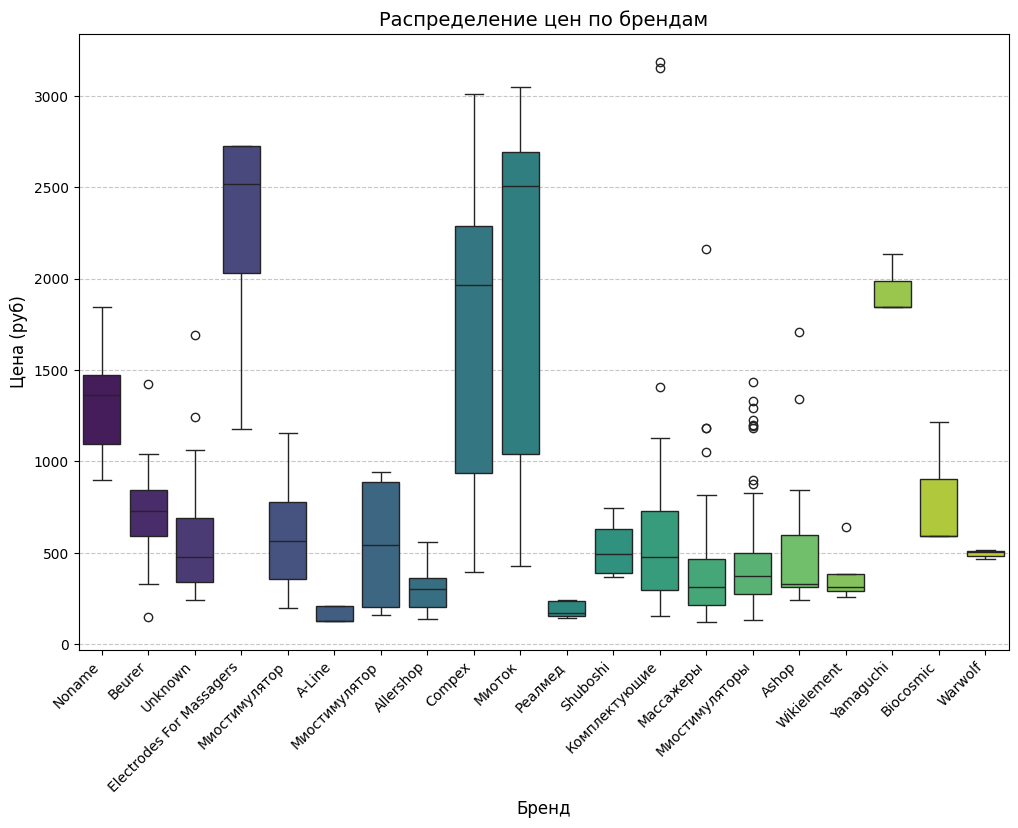

In [64]:
clear_df = Goods.copy()

boxplot_df = clear_df.dropna(subset=["brand"])
boxplot_df['brand'] = boxplot_df['brand'].str.strip().str.title()

top_brands = boxplot_df['brand'].value_counts().head(20).index  # Топ-20 брендов
df_filtered = boxplot_df[boxplot_df['brand'].isin(top_brands)]

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_filtered,
    x='brand',
    y='price',
    palette='viridis'
)
plt.title('Распределение цен по брендам', fontsize=14)
plt.xlabel('Бренд', fontsize=12)
plt.ylabel('Цена (руб)', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Поворот подписей
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [65]:
Goods['brand'].value_counts().head(20)

brand
миостимуляторы              115
массажеры                    90
миостимулятор                25
noname                       25
compex                       23
ashop                        22
комплектующие                16
wikielement                  12
allershop                    12
unknown                      12
beurer                       10
миоток                        6
a-line                        5
реалмед                       5
shuboshi                      4
electrodes for massagers      4
mиостимулятор                 4
warwolf                       3
biocosmic                     3
yamaguchi                     3
Name: count, dtype: int64

В основном товары представлены неизвестными брендами, однако несколько брендов выделяются в этой нише:
- compex
- миоток
- a-line
- shuboshi
- yamaguchi

Они являются вполне самостоятельными брендами

## Реакция потребителей (Анализ отзывов и рейтингов)

Что касается самых популярных характерстик:

In [66]:
def plot_top_main_specs(df, column, top_n, color):
    spec_df = df[column].str.split('[;,/]', expand=True).stack().str.strip()

    figsize = (15, 3)

    plt.figure(figsize=figsize)
    spec_df.value_counts().head(top_n).plot(kind='bar', color=color)
    plt.title(f'Топ-{top_n} {column}')
    plt.ylabel('Количество товаров')
    plt.xticks(rotation=30)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

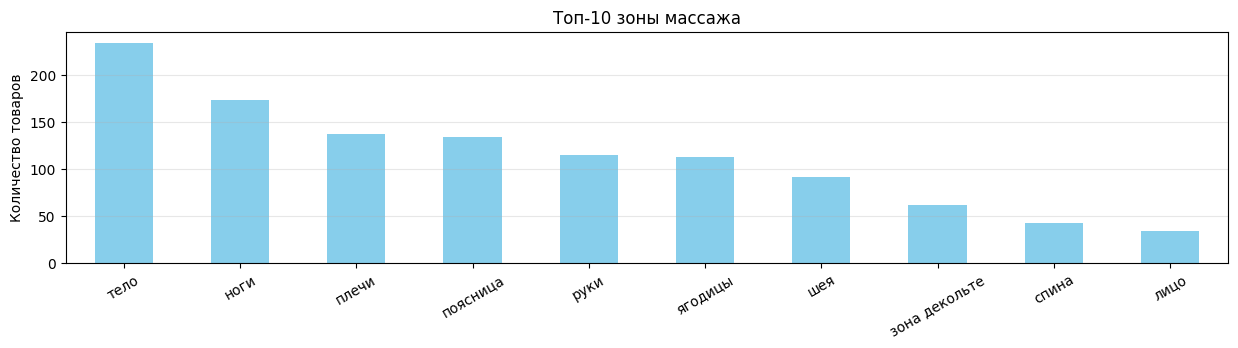

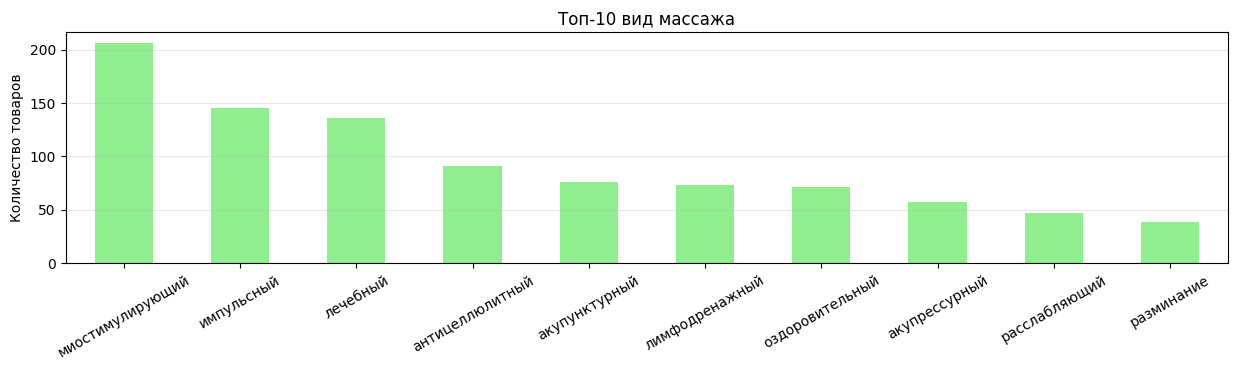

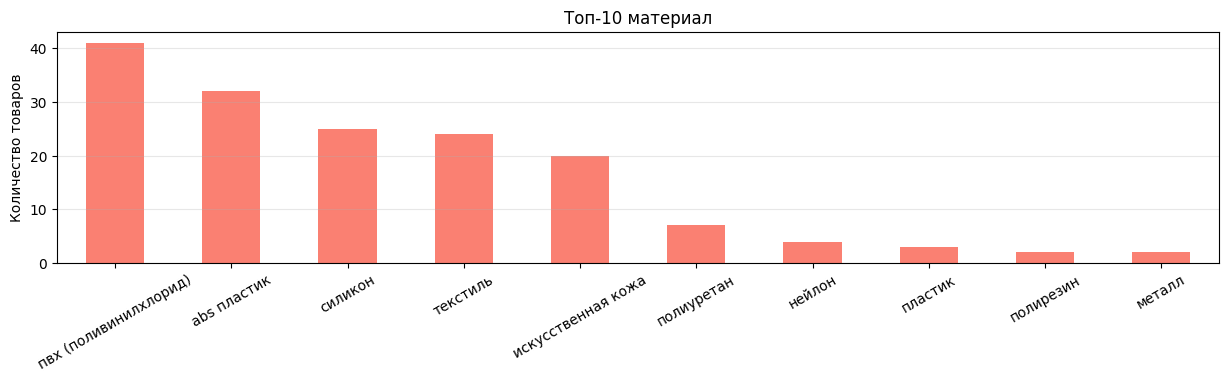

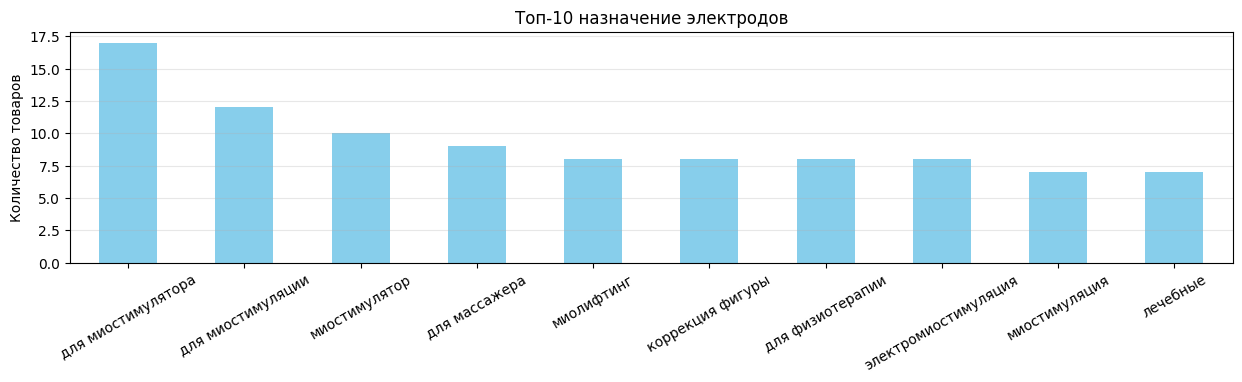

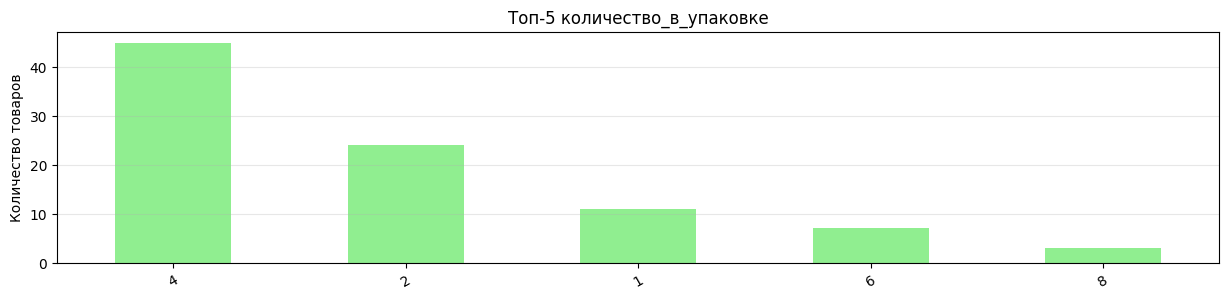

In [67]:
plot_top_main_specs(main_specs, 'зоны массажа', 10, 'skyblue')
plot_top_main_specs(main_specs, 'вид массажа', 10, 'lightgreen')
plot_top_main_specs(main_specs, 'материал', 10, 'salmon')
plot_top_main_specs(main_specs, 'назначение электродов', 10, 'skyblue')
plot_top_main_specs(main_specs, 'количество_в_упаковке', 5, 'lightgreen')

Мы видим, что на рынке представлены в основном универсальные электроды для всего тела, однако имеются и электроды сделанные под конкретную часть тела (например перчатки-электроды или носки-электроды)

Все электроды имеют ожидаемо сходные виды массажа - миостимулирующий. 

Основной материал - пластик. 

В основном на рынке представлены наборы из 4 шт. электродов.

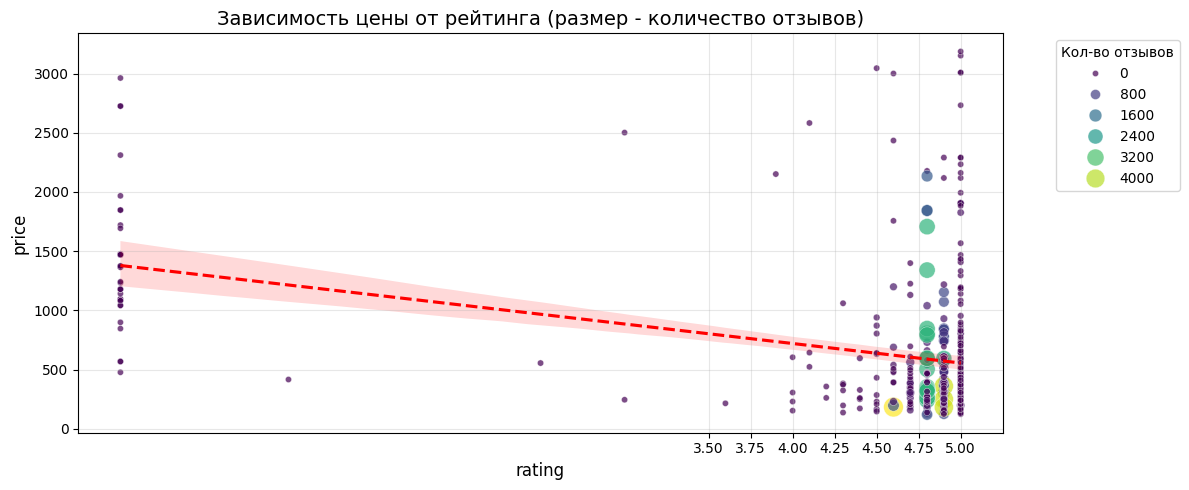

In [68]:
plt.figure(figsize=(12, 5))
sns.scatterplot(data=Goods, x='rating', y='price', 
                hue='feedbacks', size='feedbacks',
                sizes=(20, 200), alpha=0.7, palette='viridis')

plt.title('Зависимость цены от рейтинга (размер - количество отзывов)', fontsize=14)
plt.xlabel('Рейтинг', fontsize=12)
plt.ylabel('Цена (руб)', fontsize=12)
plt.xticks(np.arange(3.5, 5.1, 0.25))
plt.grid(alpha=0.3)
plt.ticklabel_format(style='plain', axis='y')

# Добавляем линию тренда
sns.regplot(data=Goods, x='rating', y='price', 
           scatter=False, color='red', line_kws={'linestyle':'--'})

plt.legend(title='Кол-во отзывов', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

Мы видим устойчивую обратную зависимость рейтинга от цены.

/var/folders/x5/m9f65fq57_1642g0ls7c0zxw0000gn/T/ipykernel_71706/1849547179.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clear_df, x='rating_group', y='price',


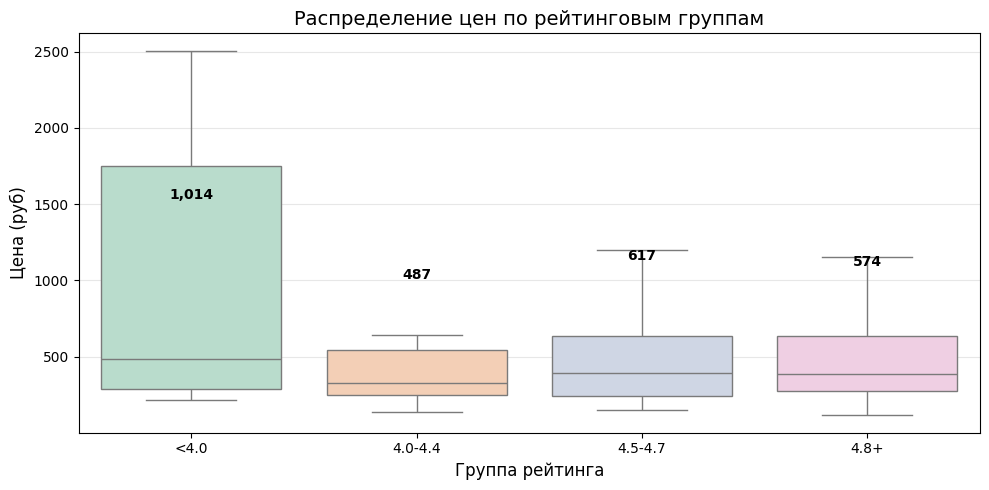

In [69]:
plt.figure(figsize=(10, 5))

clear_df = Goods.copy()

clear_df['rating_group'] = pd.cut(clear_df['rating'], 
                                   bins=[0, 3.9, 4.4, 4.7, 5],
                                   labels=['<4.0', '4.0-4.4', '4.5-4.7', '4.8+'])

sns.boxplot(data=clear_df, x='rating_group', y='price', 
           palette='Pastel2', showfliers=False)

plt.title('Распределение цен по рейтинговым группам', fontsize=14)
plt.xlabel('Группа рейтинга', fontsize=12)
plt.ylabel('Цена (руб)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Добавляем средние значения
means = clear_df.groupby('rating_group', observed=False)['price'].mean()
for i, mean in enumerate(means):
    plt.text(i, mean+500, f'{mean:,.0f}', 
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

В целом товары с высоким рейтином есть во всех ценовых сегментах, однако подавляющее большинство товаров с высоким рейтингом это средний и низкий ценовой сегмент.

#### Анализ текстов

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')

df = Feedbacks

def clean_text(text):
    if pd.isna(text): 
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('russian'))
    stemmer = SnowballStemmer('russian')
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words and len(word) > 2]
    return " ".join(words)

def generate_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        max_words=50
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()
df['text_clean'] = df['text'].apply(clean_text)

positive = df[df['rating'] > 3]
negative = df[df['rating'] <= 3]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nekitmilk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


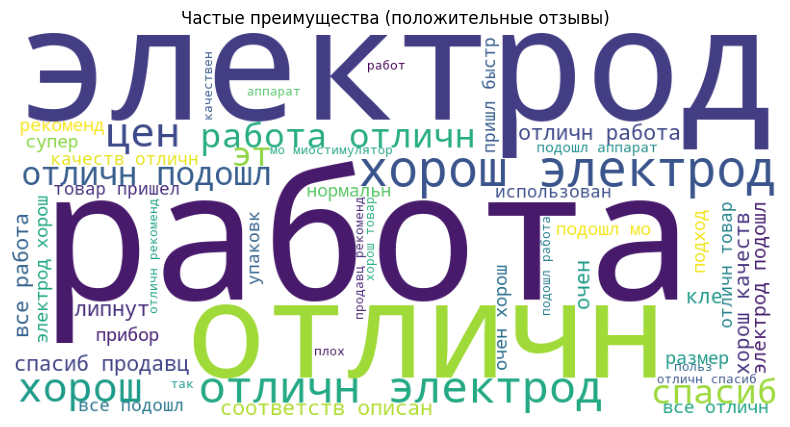

In [7]:
all_positive = " ".join(positive['text_clean'])
generate_wordcloud(all_positive, 'Частые преимущества (положительные отзывы)')

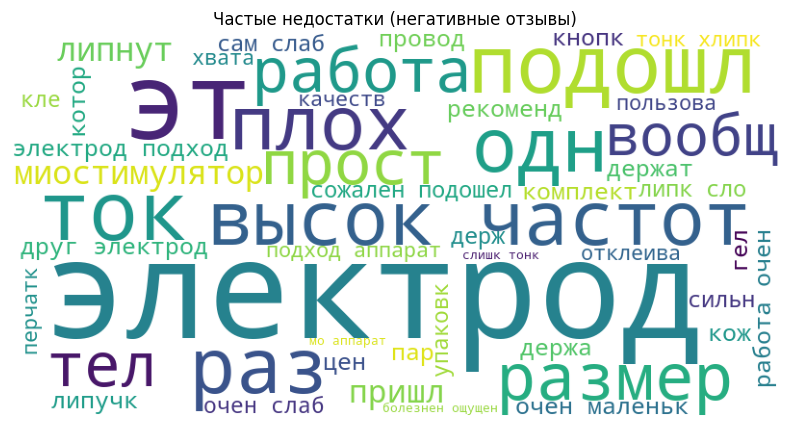

In [9]:
all_negative = " ".join(negative['text_clean'])
generate_wordcloud(all_negative, 'Частые недостатки (негативные отзывы)')

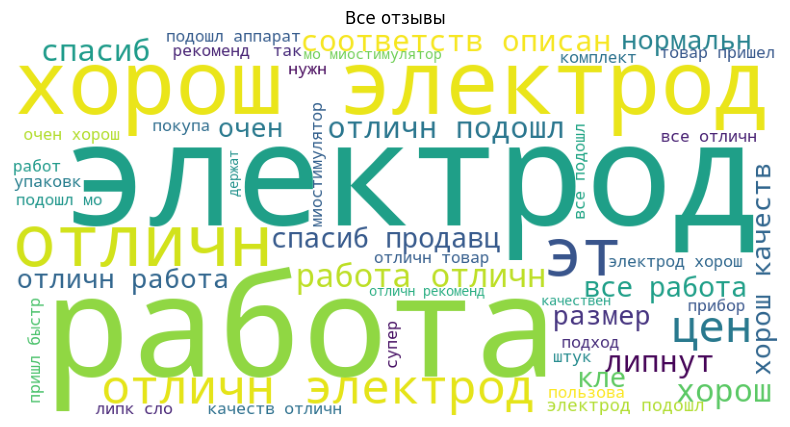

In [10]:
all_feedbacks = " ".join(df['text_clean'])
generate_wordcloud(all_feedbacks, 'Все отзывы')

In [11]:
def get_tfidf_top_features(texts, n=10, use_idf=False, use_mean=True):
    tfidf = TfidfVectorizer(max_features=100, ngram_range=(1, 2))

    tfidf_matrix = tfidf.fit_transform(texts)
    feature_names = tfidf.get_feature_names_out()
    
    if use_idf:
        sorted_indices = tfidf.idf_.argsort()
        return feature_names[sorted_indices][:n].tolist()
    
    if use_mean:
        aggregated = tfidf_matrix.mean(axis=0).A1
    else:
        aggregated = tfidf_matrix.sum(axis=0).A1
    
    sorted_indices = aggregated.argsort()[::-1]  # Сортировка по убыванию
    return feature_names[sorted_indices][:n].tolist()

In [12]:
top_positive_adv = get_tfidf_top_features(positive['text_clean'])
top_negative_dis = get_tfidf_top_features(negative['text_clean'], n=20)
print("Топ-10 слов (положительные отзывы, преимущества):", top_positive_adv)
print("Топ-20 слов (негативные отзывы, недостатки):", top_negative_dis)

Топ-10 слов (положительные отзывы, преимущества): ['отличн', 'работа', 'хорош', 'электрод', 'подошл', 'все', 'спасиб', 'рекоменд', 'очен', 'товар']
Топ-20 слов (негативные отзывы, недостатки): ['работа', 'электрод', 'очен', 'плох', 'товар', 'провод', 'использован', 'ток', 'быстр', 'пришл', 'слаб', 'подошл', 'подошел', 'аппарат', 'возврат', 'подход', 'вмест', 'миостимулятор', 'кле', 'одн']


In [13]:
print(f"Доля позитивных отзывов от общего количества: {(len(positive)*100/(len(positive) + len(negative))):.2f}%")

Доля позитивных отзывов от общего количества: 92.26%


Потребители в основном оценивают данные устроства положительно. 

В негативных отзывах сложно выделить основные жалобы, но можно отметить:
- жалобы на размер
- липучки
- электрод не подошел
- комплект

## Выводы:

В основной массе пользователи положительно оценивают данные товары (> 90% положительных отзывов).

Идеальный продукт выглядит так: набор из 4-х шт. качественных электродов общего назначения из среднего или низкого ценового сегмента. Большинство товаров не имеют какого-то очень известного бренда (можно отметить Shuboshi, Yamaguchi, Compex, Миоток, A-line). 

Идеальный сегмент для запуска - средний, поскольку конкуренция в нем относительно невысока, имеется относительно высокий спрос и высокие оценки от потребителей.

Не идеальный - средне-высокий, в связи с тем, что имеет низкие и немногочисленные оценки потребителя.

Конкуренция на рынке относительно низкая, поскольку на 2-х крупнеших маркетплейсах (Ozon и Wildberries) представлено < 500 товаров. 